###Constants

$C_0 = 0.05$</br>
$m_l = -81.1$</br>
$m_s = -478$</br>
$c_p = 820$</br>
$ρ = 7000$</br>
$L_f = 276000$</br>
$T_f = 1538$</br>
$T_∞ = 1540$</br>
$T_0 = 1510$</br>
$k_0 = 0.17$</br>
$Le = 300$</br>

$Ste = c_p(T_∞-T_0)/L_f$</br>
$θ_f = (T_f-T_0)/(T_∞-T_0)$

###Conditions

Domain $\epsilon \in [0,ϵ^*]$</br>
$C_s = k_0C_l^*$</br>
PDE1: $\frac{∂\theta_s}{∂\tau} = \frac{∂^2\theta_s}{∂\epsilon^2}$</br>
Domain $\epsilon \in [ϵ^*,1]$</br>
PDE2: $\frac{∂\theta_l}{∂\tau} = \frac{∂^2\theta_l}{∂\epsilon^2}$</br>
PDE3: $\frac{∂C_l}{∂\tau} = \frac{1}{Le}\frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface ($ϵ=ϵ^*$)</br>
PDE4: $\frac{1}{Ste}\frac{∂\epsilon^*}{∂\tau} = \frac{∂\theta_s}{∂\epsilon}-\frac{∂\theta_l}{∂\epsilon}$</br>
PDE5: $\frac{-1}{Le}\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)\frac{dϵ^*}{dτ}$</br>

5 PDEs with 5 Variables [$θ_s(x,t)$, $θ_l(x,t)$, $C_s(x,t)$, $C_l(x,t)$, $ϵ^*(t)$]</br>
Model the 5 variables using 3 neural networks and optimise the NN parameters</br>

Initial ($\tau = 0$)</br>
$θ_l=1$ ; $C_l=C_0$ ; $ϵ^*=0$</br>
Interface ($ϵ=ϵ^*$)</br>
$θ_s=θ_l=θ^*$</br>
$C_l^* = (T_0-T_∞)(θ_f-θ^*)/m_l$</br>
Left BC ($ϵ=0$)</br>
$θ_s=0$

##Code

In [ ]:
import tensorflow as tf
import numpy as np
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0, phi = 0.05*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.17*a, 0.1159*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
def C_(u_):
  return (T0-Ti)*(uf-u_)/ml # concentration of liquid at interface (Cl*) given interface temp

###Evaluating PDEs

In [ ]:
def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - u2_xx

def f3(c_t, c_xx): # calculates PDE3 value given c's derivatives
  return c_t - (c_xx/Le)

def f4(s_t, u1_x, u2_x): # calculates PDE4 value
  return (s_t/Ste) - u1_x + u2_x

def f5(c_x, cstar, s_t): # calculates PDE5 value
  return (cstar*(1-k0)*s_t)+(c_x/Le)

###Analytical Solutions

In [ ]:
def u1_anal(t,x): # calculates u1 value from its analytical solution
  return ustar*tf.math.erf(x/(2*(t**0.5)))/tf.math.erf(phi)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return 1-((1-ustar)*tf.math.erfc(x/(2*(t**0.5)))/tf.math.erfc(phi))

c1_anal = k0*C_(ustar) # analytical value of Cs

def c2_anal(t,x): # calculates c2 value from its analytical solution
  return C0 + ((C_(ustar)-C0)*tf.math.erfc((x*(Le**0.5))/(2*(t**0.5)))/tf.math.erfc(phi*(Le**0.5)))

def s_anal(t): # calculates s value from its analytical solution
  return 2*phi*(t**0.5)

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

def c_anal(t,x): # analytical value of c given x and t
  return tf.where(tf.math.greater(s_anal(t),x),c1_anal,c2_anal(t,x))

###Training Data

In [ ]:
Nm = 200 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm = tf.random.uniform((Nm,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xm = tf.random.uniform((Nm,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points

###Optional Data

In [ ]:
Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xb = tf.ones((Nb,1))*xmin # xmin repeated Nb times
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

###Modelling Variables

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for c1 and c2
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

###Compute gradients to return PDE values

In [ ]:
def get_f(umodel, smodel, cmodel, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    c = cmodel(tf.concat([t, x], axis=1)) # c1 and c2 as functions of t and x
    c1, c2 = c[:, 0:1], c[:, 1:2]
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    cb = cmodel(tf.concat([t, s], axis=1))[:, 1:2]
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

###Calculating loss

In [ ]:
def loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll): # compute Loss given model and data

  tc = coll[:,0:1]
  psb = smodel(tc) # Predicted Interface positions
  pub = umodel(tf.concat([tc, psb], axis=1)) # Interface Temperature prediction
  pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
  pcb = cmodel(tf.concat([tc, psb], axis=1))[:, 1:2] # Interface Concentration prediction
  xi = tf.zeros(shape=tf.shape(tc), dtype=DTYPE)
  pu0b = umodel(tf.concat([tc, xi], axis=1))[:, 0:1] # Left boundary temperature prediction
  Lb1 = tf.reduce_mean(tf.square(pu0b))
  Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
  Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))

  pc1 = cmodel(coll)[:,0:1]
  Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb)))

  init = tf.constant(0,shape=(1,1))
  init2 = tf.concat([xi, coll[:,1:2]], axis=1)
  pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
  pc2i = cmodel(init2)[:, 1:2] # predicted initial conc of liquid
  Li1 = tf.squeeze(tf.square(smodel(init)))
  Li2 = tf.reduce_mean(tf.square(pc2i-C0))
  Li3 = tf.reduce_mean(tf.square(pu2i-a))

  pum = umodel(mea) # Temperature prediction on measurement data
  pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
  pcm = cmodel(mea) # Concentration prediction on measurement data
  pc1m, pc2m =  pcm[:, 0:1], pcm[:, 1:2]
  psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
  pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
  pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
  Lm1 = tf.reduce_mean(tf.square(um - pum))
  Lm2 = tf.reduce_mean(tf.square(cm - pcm))

  f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
  Lc1 = tf.reduce_mean(tf.square(f_1))
  Lc2 = tf.reduce_mean(tf.square(f_2))
  Lc3 = tf.reduce_mean(tf.square(f_3))
  Lc4 = tf.reduce_mean(tf.square(f_4))
  Lc5 = tf.reduce_mean(tf.square(f_5))

  losses = [Lb1,Lb2,Lb3,Ls,Li1,Li2,Li3,Lc1,Lc2,Lc3,Lc4,Lc5,Lm1,Lm2]

  return losses

###Computing Loss Gradients

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, mea, um, cm, coll, lamb1, lamb2, lamb3): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn(umodel, smodel, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lur = losses[7] + losses[8]
    Lcr = losses[9] + losses[3]
    Lud = losses[-2]
    Lcd = losses[-1]
    Lub = losses[0] + losses[1]
    loss = sum(losses[2:12]) + lamb1*Lud + lamb2*Lcd + lamb3*Lub
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gub = tape.gradient(Lub, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gu, gs, gc, gur, gud, gub, gcr, gcd

### Training

In [ ]:
Nc = 10000 # No of collocation points
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
cmodel = c_model() # initialise the Conc NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,2000,3000,4000],[5e-3,1e-3,5e-4,1e-4,5e-5]) # decreasing learning rate which is piecewise constant
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr) # Adam Optimiser

In [ ]:
def train_step(coll,lamb1,lamb2,lamb3):
  # compute loss and its gradient wrt model parameters
  losses, gu, gs, gc, gur, gud, gub, gcr, gcd = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, coll, lamb1, lamb2, lamb3)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  fgub = tf.concat([tf.reshape(g,[-1]) for g in gub if g is not None],axis=-1)
  denom3 = tf.reduce_mean(tf.math.abs(fgub))
  new_lamb3 = numer1/denom3
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return losses, new_lamb1, new_lamb2, new_lamb3

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2, lamb3 = 0.1, 0.1, 0.1
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2, lamb3 = train_step(coll,lamb1,lamb2,lamb3)
  if i%1000 == 0:
      print([num.numpy() for num in loss_comps]) # recording loss components every 1000 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.00073956494, 4.3624063e-05, 57.43242, 1.6706805, 11.462716, 0.2929295, 0.35778567, 3.172378, 2.7855246, 48.223198, 711.5305, 235.63554, 0.0013291106, 0.000737169]
[0.0006973056, 4.4284316e-05, 28.314337, 0.7950416, 8.033434, 0.36585125, 0.4320703, 1.7221974, 2.8000138, 26.044094, 340.80185, 63.556812, 0.00074957544, 0.00045628956]
[0.00027430058, 2.5357527e-05, 32.34298, 0.9080248, 5.5091023, 0.39568615, 0.2697815, 1.4454474, 2.1587422, 13.463407, 126.83549, 14.454385, 0.00053211994, 0.00040941036]
[0.0003791547, 0.00052839477, 6.574926, 0.18082996, 3.984712, 0.42799604, 0.13495527, 1.5548041, 1.9919856, 18.12985, 35.893982, 0.33291972, 0.00035280286, 0.00037522937]
[0.00013802949, 0.000100571655, 5.5565877, 0.15212344, 3.876608, 0.46734154, 0.07533715, 1.6052061, 1.458426, 15.433912, 21.466587, 0.37995756, 0.00021360494, 0.00035354]
Final Loss = 50.472897
Computation Time = 118.67260626951854 minutes


Text(0, 0.5, 'Loss')

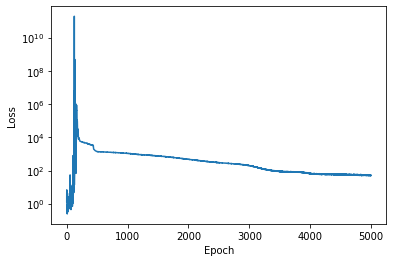

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
lamb1, lamb2, lamb3

(<tf.Tensor: shape=(), dtype=float32, numpy=450817.3>,
 <tf.Tensor: shape=(), dtype=float32, numpy=756811460.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=32521.137>)

Text(0, 0.5, 'u (Temperature)')

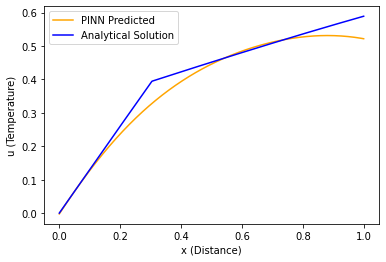

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(2.7501338, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

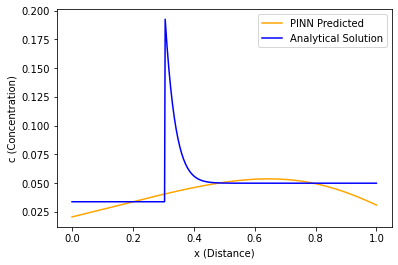

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

### Results for implementation with only 2 adaptive weights (take lamb3 = 1 as constant)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 0.1, 0.1
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step(coll,lamb1,lamb2)
  if i%1000 == 0:
      print([num.numpy() for num in loss_comps]) # recording loss components every 1000 epochs
  loss = sum(loss_comps[0:12]) + lamb1*loss_comps[-2] + lamb2*loss_comps[-1]
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.018545585, 0.010147646, 0.0018644237, 3.6924866e-05, 0.0005143813, 0.0003615145, 0.00798756, 0.70840836, 1.8633168, 0.00011289456, 0.00052044354, 0.0007220347, 5.5082575e-05, 0.0005724726]
[0.0030681107, 0.0077500762, 0.005558725, 0.00015639354, 8.099421e-05, 1.7259758e-06, 0.0067787804, 0.11519992, 2.1904204, 0.020424737, 0.0009326799, 0.00075685757, 2.8671224e-05, 6.8435106e-06]
[0.004714514, 9.8563505e-05, 0.065843895, 0.00085195084, 0.019329986, 7.043407e-05, 0.006758232, 1.599351, 3.4777055, 0.020987375, 0.002522231, 2.6641356e-07, 4.292398e-06, 4.6984223e-06]
[0.0062660486, 0.001604052, 0.021324571, 0.00092481595, 0.0032319443, 2.19677e-05, 0.006929142, 1.0794892, 2.8173265, 0.024672898, 0.020090878, 0.00072860566, 7.957714e-06, 1.2163708e-05]
[0.0044043944, 0.005635516, 0.008216085, 0.0004013895, 1.8325433e-06, 1.9391093e-05, 0.007924854, 0.91195565, 3.5469594, 0.042936478, 0.006906753, 0.0011345621, 2.0805846e-06, 9.3679716e-07]
Final Loss = 104.67288
Computation Time = 133.

In [ ]:
lamb1, lamb2

(<tf.Tensor: shape=(), dtype=float32, numpy=46978240.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2555705.0>)

Text(0, 0.5, 'Loss')

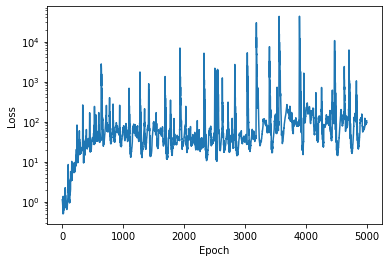

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

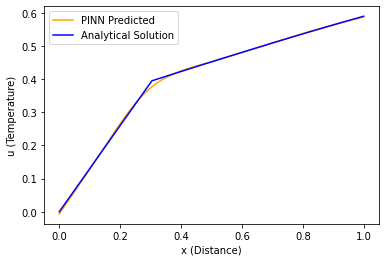

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(-0.14014997, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

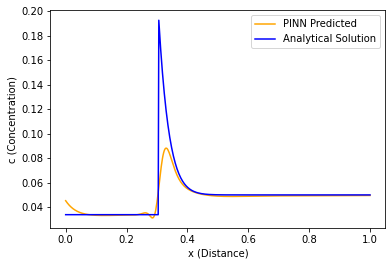

In [ ]:
cpred = cmodel(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

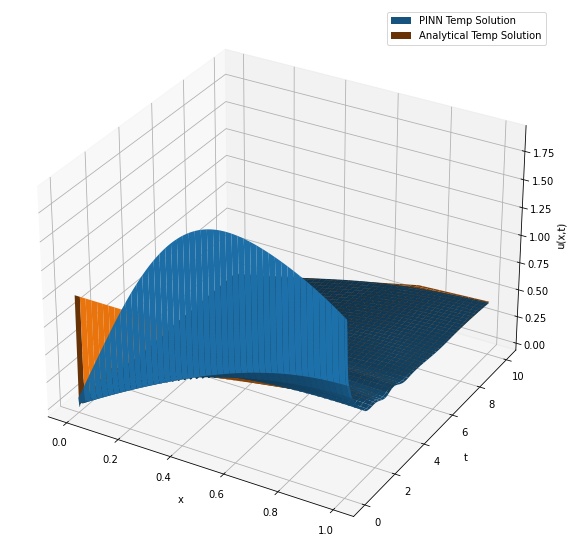

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = umodel(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

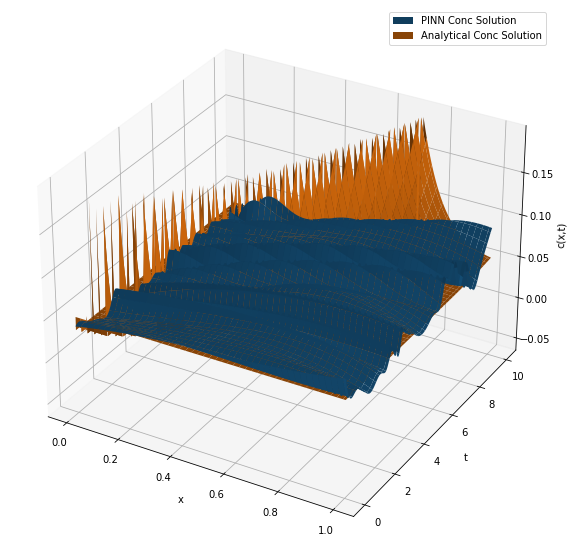

In [ ]:
c_pred = cmodel(input)
c1_p, c2_p = c_pred[:, 0:1], c_pred[:, 1:2]
cp = tf.where(tf.math.greater(s_pred,x_inp), c1_p, c2_p)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

Text(0.5, 1.0, 'Predicted vs Actual Movement of Interface')

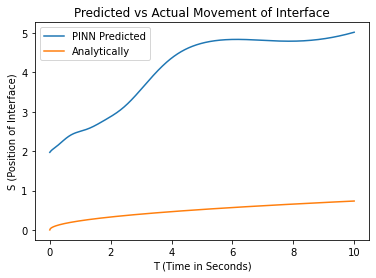

In [ ]:
t_values = tf.cast(tspace,DTYPE)
s_values = smodel(t_values)
s_exact = s_anal(t_values)
plt.plot(t_values,s_values)
plt.plot(t_values,s_exact)
plt.legend(['PINN Predicted','Analytically'])
plt.xlabel('T (Time in Seconds)')
plt.ylabel('S (Position of Interface)')
plt.title('Predicted vs Actual Movement of Interface')